In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Percobaan/indonesia_dataset.csv')

Mounted at /content/drive


In [ ]:
data = df.dropna(subset=['summary', 'text'])

In [ ]:
import re
import string

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Bahasa Indonesia dan Inggris (bisa disesuaikan)
stop_words = set(stopwords.words('indonesian') + stopwords.words('english'))

# Fungsi cleaning teks
def clean_text(text):
    text = str(text).lower()  # huruf kecil semua
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # hapus URL
    text = re.sub(r'\d+', '', text)  # hapus angka
    text = text.translate(str.maketrans('', '', string.punctuation))  # hapus tanda baca
    text = re.sub(r'\s+', ' ', text).strip()  # hapus spasi ganda
    return text

# Tokenisasi dan hapus stopwords
def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Gabungkan kedua tahap
def preprocess_text(text):
    cleaned = clean_text(text)
    return tokenize_and_remove_stopwords(cleaned)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
df['clean_text'] = df['text'].apply(preprocess_text)
df['clean_summary'] = df['summary'].apply(preprocess_text)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])
print("TF-IDF matrix shape:", tfidf_matrix.shape)

TF-IDF matrix shape: (38242, 194032)


In [ ]:
first_row_tfidf = tfidf_matrix[0]

feature_names = tfidf_vectorizer.get_feature_names_out()
words_and_scores_first_row = [(feature_names[col], score) for col, score in zip(first_row_tfidf.indices, first_row_tfidf.data)]

# Sortir berdasarkan skor TF-IDF (opsional)
words_and_scores_first_row_sorted = sorted(words_and_scores_first_row, key=lambda item: item[1], reverse=True)

print("\nTF-IDF representation for the first document (clean_text):")
# Cetak beberapa kata dengan skor TF-IDF tertinggi (atau semua jika ingin)
for word, score in words_and_scores_first_row_sorted[:20]: # Cetak 20 kata teratas
    print(f"  {word}: {score:.4f}")


TF-IDF representation for the first document (clean_text):
  gajah: 0.7005
  mengamuk: 0.3379
  lanka: 0.2786
  sri: 0.2273
  upacara: 0.2131
  peserta: 0.1359
  hias: 0.1235
  kontan: 0.1126
  prosesi: 0.0945
  menginjak: 0.0917
  kuil: 0.0882
  menabrak: 0.0864
  keperluan: 0.0842
  kaget: 0.0834
  viral: 0.0824
  tarik: 0.0822
  berlari: 0.0816
  tersendiri: 0.0816
  simak: 0.0805
  diperbolehkan: 0.0800


In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

n_components = 100  # Contoh: 100 komponen

# Inisialisasi model LSA (TruncatedSVD)
lsa_model = TruncatedSVD(n_components=n_components, random_state=42)

# Latih model LSA pada matriks TF-IDF
lsa_matrix = lsa_model.fit_transform(tfidf_matrix)

print("\nLSA matrix shape:", lsa_matrix.shape)

# Anda bisa melihat komponen utama atau "topik" yang ditemukan oleh LSA
print("\nExplained variance ratio by LSA components:")
print(lsa_model.explained_variance_ratio_)
print("\nTotal explained variance:", np.sum(lsa_model.explained_variance_ratio_))


# Transform ringkasan menggunakan vectorizer TF-IDF yang sama
tfidf_matrix_summary = tfidf_vectorizer.transform(df['clean_summary'])

# Transform matriks TF-IDF ringkasan menggunakan model LSA yang sudah dilatih
lsa_matrix_summary = lsa_model.transform(tfidf_matrix_summary)

print("\nLSA matrix shape for summaries:", lsa_matrix_summary.shape)

# Hitung kesamaan kosinus antara representasi LSA teks asli dan ringkasan
# Semakin tinggi kesamaan, semakin baik ringkasan merepresentasikan teks asli dalam ruang LSA.
cosine_similarities = [cosine_similarity(lsa_matrix[i].reshape(1, -1), lsa_matrix_summary[i].reshape(1, -1))[0][0] for i in range(lsa_matrix.shape[0])]

# Tambahkan kolom kesamaan kosinus ke DataFrame
df['lsa_cosine_similarity'] = cosine_similarities

# Cetak beberapa contoh kesamaan kosinus
print("\nFirst 5 LSA Cosine Similarities (Text vs Summary):")
print(df['lsa_cosine_similarity'].head())

# Cetak rata-rata kesamaan kosinus
print("\nAverage LSA Cosine Similarity (Text vs Summary):", np.mean(df['lsa_cosine_similarity']))


LSA matrix shape: (38242, 100)

Explained variance ratio by LSA components:
[0.00199977 0.00851747 0.00506941 0.00455938 0.00419705 0.00391952
 0.00355163 0.00333641 0.00307822 0.00293707 0.0026891  0.00259794
 0.00253328 0.00244793 0.00240375 0.00229205 0.00220438 0.00214794
 0.00204038 0.00200851 0.00198129 0.00195092 0.00187552 0.00178572
 0.00174564 0.00173225 0.00171177 0.00168246 0.00164989 0.00163221
 0.00160901 0.00156579 0.00156252 0.00154281 0.00151375 0.00150423
 0.00147936 0.00146406 0.00144114 0.00141218 0.00140968 0.00137242
 0.00135387 0.00134545 0.00133277 0.00131861 0.00130522 0.00129872
 0.00126967 0.00124914 0.00123171 0.00121698 0.00120149 0.00118291
 0.0011573  0.00114127 0.00112523 0.0011151  0.00109394 0.00107731
 0.00106728 0.00104876 0.00103769 0.00102563 0.00101556 0.0009967
 0.00099186 0.00097543 0.0009538  0.00095264 0.00094309 0.000938
 0.00093306 0.00092393 0.00091114 0.00090311 0.00089344 0.00087816
 0.00086777 0.00086519 0.00085888 0.00084889 0.00084603

In [ ]:
!pip install rouge_score

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24987 sha256=3d0fc47d191e2cce36d0aee6a3c98e0f654dab7cc5bbf8199770721783d4fc1c
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

reference_summary = str(df['summary'].iloc[0])  # Gunakan iloc agar aman
source_text = str(df['text'].iloc[0])


# ROUGE score antara clean_summary dan clean_text
scores = scorer.score(source_text, reference_summary)

print("\nROUGE scores (comparing clean_text vs clean_summary):")
for key, value in scores.items():
    print(f"  {key}: {value}")


all_rouge_scores = []

# Iterasi melalui setiap baris DataFrame
for index, row in df.iterrows():
    # Gunakan teks yang sudah diproses
    text = row['clean_text']
    summary = row['clean_summary']

    # Hitung ROUGE score
    scores = scorer.score(text, summary)
    all_rouge_scores.append(scores)

# Mengumpulkan skor rata-rata
rouge1_precision = np.mean([score['rouge1'].precision for score in all_rouge_scores])
rouge1_recall = np.mean([score['rouge1'].recall for score in all_rouge_scores])
rouge1_fmeasure = np.mean([score['rouge1'].fmeasure for score in all_rouge_scores])

rouge2_precision = np.mean([score['rouge2'].precision for score in all_rouge_scores])
rouge2_recall = np.mean([score['rouge2'].recall for score in all_rouge_scores])
rouge2_fmeasure = np.mean([score['rouge2'].fmeasure for score in all_rouge_scores])

# Perbaiki typo 'lougeL' menjadi 'rougeL'
rougel_precision = np.mean([score['rougeL'].precision for score in all_rouge_scores])
rougel_recall = np.mean([score['rougeL'].recall for score in all_rouge_scores])
rougel_fmeasure = np.mean([score['rougeL'].fmeasure for score in all_rouge_scores])


print("\nAverage ROUGE scores (comparing clean_text vs clean_summary across dataset):")
print(f"  ROUGE-1 Precision: {rouge1_precision:.4f}, Recall: {rouge1_recall:.4f}, F-measure: {rouge1_fmeasure:.4f}")
print(f"  ROUGE-2 Precision: {rouge2_precision:.4f}, Recall: {rouge2_recall:.4f}, F-measure: {rouge2_fmeasure:.4f}")
print(f"  ROUGE-L Precision: {rougel_precision:.4f}, Recall: {rougel_recall:.4f}, F-measure: {rougel_fmeasure:.4f}")



ROUGE scores (comparing clean_text vs clean_summary):
  rouge1: Score(precision=0.43478260869565216, recall=0.09900990099009901, fmeasure=0.16129032258064516)
  rouge2: Score(precision=0.13636363636363635, recall=0.03, fmeasure=0.04918032786885246)
  rougeL: Score(precision=0.30434782608695654, recall=0.06930693069306931, fmeasure=0.11290322580645161)

Average ROUGE scores (comparing clean_text vs clean_summary across dataset):
  ROUGE-1 Precision: 0.6376, Recall: 0.0572, F-measure: 0.1021
  ROUGE-2 Precision: 0.2301, Recall: 0.0186, F-measure: 0.0335
  ROUGE-L Precision: 0.4937, Recall: 0.0432, F-measure: 0.0774


In [16]:
# 1. Import library
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from rouge_score import rouge_scorer

# 2. Buat TF-IDF dari teks asli
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])

# 3. Latih model LSA
n_components = 100
lsa_model = TruncatedSVD(n_components=n_components, random_state=42)
lsa_matrix = lsa_model.fit_transform(tfidf_matrix)

# 4. Transform ringkasan menggunakan TF-IDF dan LSA yang sama
tfidf_matrix_summary = tfidf_vectorizer.transform(df['clean_summary'])
lsa_matrix_summary = lsa_model.transform(tfidf_matrix_summary)

# 5. Hitung cosine similarity antara teks dan ringkasan dalam ruang LSA
cosine_similarities = [
    cosine_similarity(lsa_matrix[i].reshape(1, -1), lsa_matrix_summary[i].reshape(1, -1))[0][0]
    for i in range(lsa_matrix.shape[0])
]

# 6. Tambahkan ke DataFrame
df['lsa_cosine_similarity'] = cosine_similarities

# 7. Hitung ROUGE-1 F-measure per pasangan teks vs ringkasan
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_fmeasures = []
for index, row in df.iterrows():
    ref = str(row['clean_text'])
    pred = str(row['clean_summary'])
    score = scorer.score(ref, pred)
    rouge1_fmeasures.append(score['rouge1'].fmeasure)


df['rouge1'] = rouge1_fmeasures

# 8. Evaluasi ambiguitas semantik
eval_df = pd.DataFrame(df)
eval_df['semantic_ambiguity'] = (
    (eval_df['rouge1'] > 0.5) &
    (eval_df['lsa_cosine_similarity'] < 0.7)
)

# 9. Tampilkan ringkasan evaluasi
print(eval_df[['rouge1', 'lsa_cosine_similarity', 'semantic_ambiguity']].head())

# 10. Simpan hasil evaluasi
eval_df.to_csv("evaluasi_lsa_semantic_ambiguity.csv", index=False)
print("✅ Hasil evaluasi disimpan ke evaluasi_lsa_semantic_ambiguity.csv")


     rouge1  lsa_cosine_similarity  semantic_ambiguity
0  0.230769               0.871997               False
1  0.069388               0.629685               False
2  0.125000               0.937288               False
3  0.000000               0.162197               False
4  0.049020               0.835632               False
✅ Hasil evaluasi disimpan ke evaluasi_lsa_semantic_ambiguity.csv


In [18]:
# 1. Import library
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from rouge_score import rouge_scorer

# 2. TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])

# 3. Latih model LSA
n_components = 100
lsa_model = TruncatedSVD(n_components=n_components, random_state=42)
lsa_matrix = lsa_model.fit_transform(tfidf_matrix)

# 4. Transform ringkasan ke LSA
tfidf_matrix_summary = tfidf_vectorizer.transform(df['clean_summary'])
lsa_matrix_summary = lsa_model.transform(tfidf_matrix_summary)

# 5. Hitung cosine similarity antara teks & ringkasan
cosine_similarities = [
    cosine_similarity(lsa_matrix[i].reshape(1, -1), lsa_matrix_summary[i].reshape(1, -1))[0][0]
    for i in range(lsa_matrix.shape[0])
]
df['lsa_cosine_similarity'] = cosine_similarities

# 6. Hitung ROUGE-1, ROUGE-2, ROUGE-L F-measure
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_f, rouge2_f, rougel_f = [], [], []

for index, row in df.iterrows():
    ref = str(row['clean_text'])
    pred = str(row['clean_summary'])
    score = scorer.score(ref, pred)

    rouge1_f.append(score['rouge1'].fmeasure)
    rouge2_f.append(score['rouge2'].fmeasure)
    rougel_f.append(score['rougeL'].fmeasure)

df['rouge1'] = rouge1_f
df['rouge2'] = rouge2_f
df['rougeL'] = rougel_f

# 7. Evaluasi Semantic Ambiguity (dengan threshold)
eval_df = pd.DataFrame(df)
eval_df['semantic_ambiguity'] = (
    (eval_df['rouge1'] > 0.5) &
    (eval_df['lsa_cosine_similarity'] < 0.7)
)

# 8. Tampilkan ringkasan hasil evaluasi
print(eval_df[['rouge1', 'rouge2', 'rougeL', 'lsa_cosine_similarity', 'semantic_ambiguity']].head())

# 9. Simpan hasil evaluasi ke CSV
eval_df.to_csv("evaluasi_lsa_rouge_semantic_ambiguity.csv", index=False)
print("✅ Hasil evaluasi disimpan ke evaluasi_lsa_rouge_semantic_ambiguity.csv")


     rouge1    rouge2    rougeL  lsa_cosine_similarity  semantic_ambiguity
0  0.230769  0.105263  0.153846               0.871997               False
1  0.069388  0.020492  0.053061               0.629685               False
2  0.125000  0.063830  0.125000               0.937288               False
3  0.000000  0.000000  0.000000               0.162197               False
4  0.049020  0.026230  0.035948               0.835632               False
✅ Hasil evaluasi disimpan ke evaluasi_lsa_rouge_semantic_ambiguity.csv


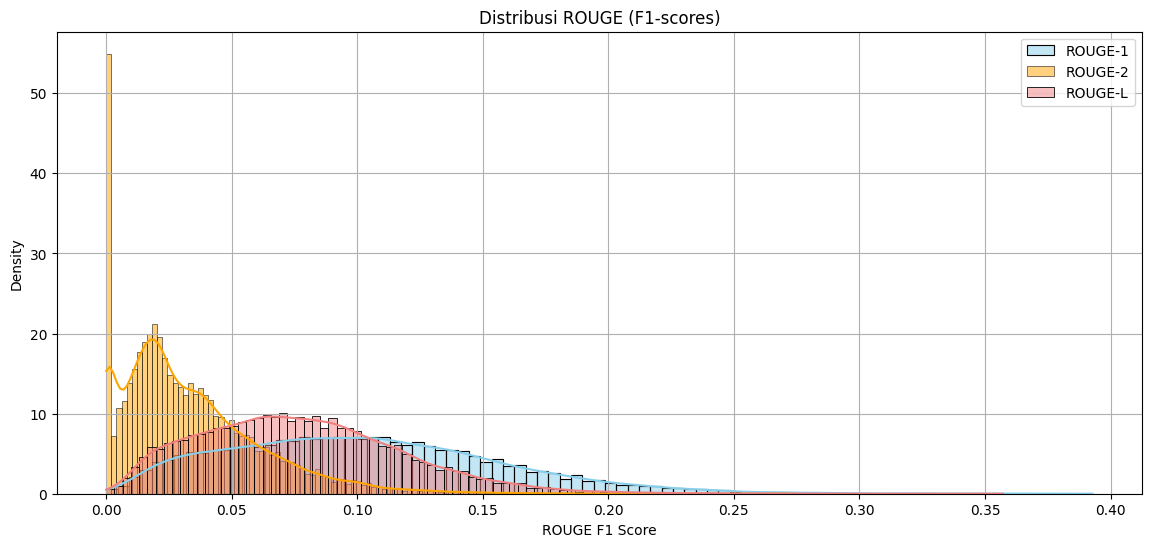

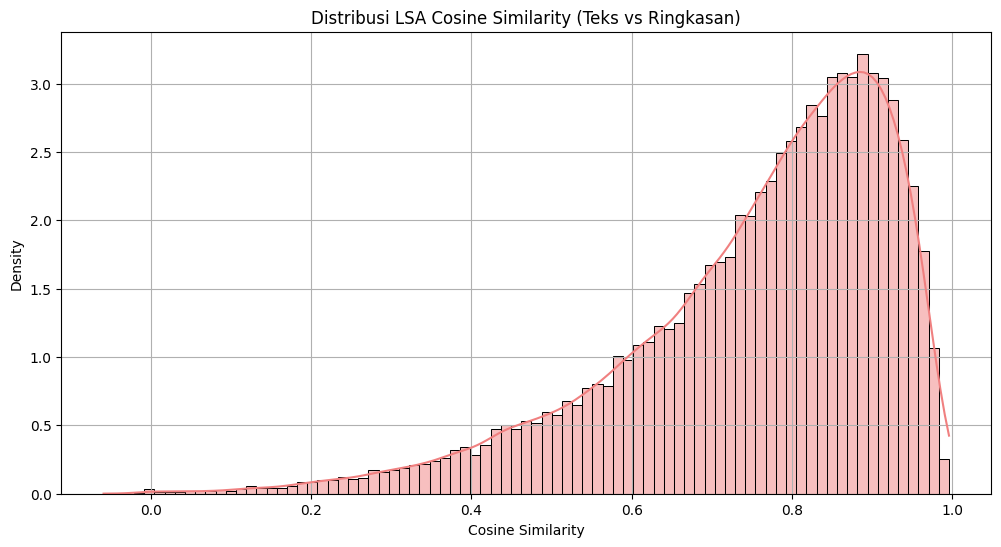

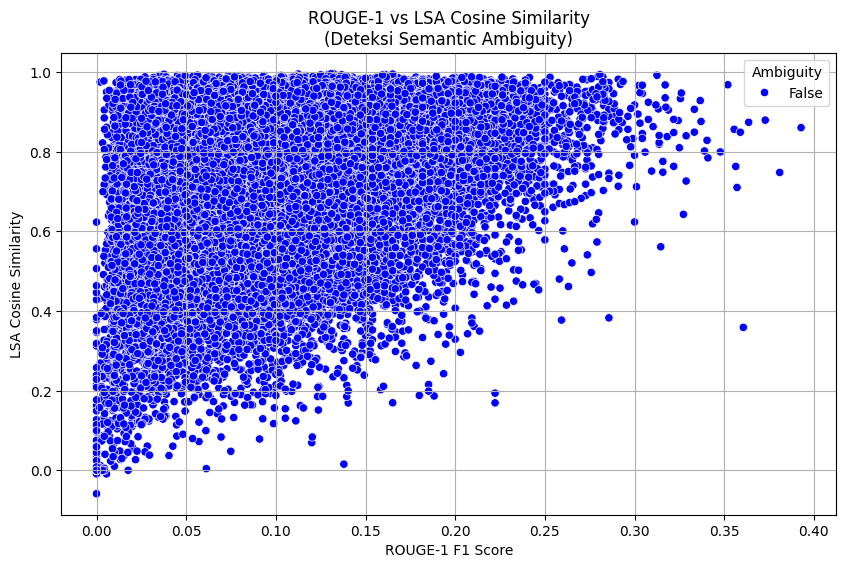

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Histogram distribusi ROUGE-1, ROUGE-2, dan ROUGE-L
plt.figure(figsize=(14, 6))
sns.histplot(eval_df['rouge1'], color='skyblue', kde=True, label='ROUGE-1', stat='density')
sns.histplot(eval_df['rouge2'], color='orange', kde=True, label='ROUGE-2', stat='density')
sns.histplot(eval_df['rougeL'], color='lightcoral', kde=True, label='ROUGE-L', stat='density')
plt.title('Distribusi ROUGE (F1-scores)')
plt.xlabel('ROUGE F1 Score')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# 2. Histogram distribusi LSA Cosine Similarity
plt.figure(figsize=(12, 6))
sns.histplot(eval_df['lsa_cosine_similarity'], color='lightcoral', kde=True, stat='density')
plt.title('Distribusi LSA Cosine Similarity (Teks vs Ringkasan)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# 3. Scatter Plot: ROUGE-1 vs LSA Cosine Similarity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rouge1', y='lsa_cosine_similarity', hue='semantic_ambiguity', data=eval_df, palette={True: 'red', False: 'blue'})
plt.title('ROUGE-1 vs LSA Cosine Similarity\n(Deteksi Semantic Ambiguity)')
plt.xlabel('ROUGE-1 F1 Score')
plt.ylabel('LSA Cosine Similarity')
plt.grid(True)
plt.legend(title='Ambiguity')
plt.show()
